In [1]:
import os
import matplotlib.pyplot as plt
import random as rnd
import math
import numpy as np
import cv2

## Dataset

In [2]:
directory = "fruits-dataset"
data = np.array(
    [
        [path.split("/")[-1], cv2.imread(path + "/" + file)]
        for path, _, files in os.walk(directory)
        for file in files
    ],
    dtype=object
)

print(f"{len(data)} images found.")

286 images found.


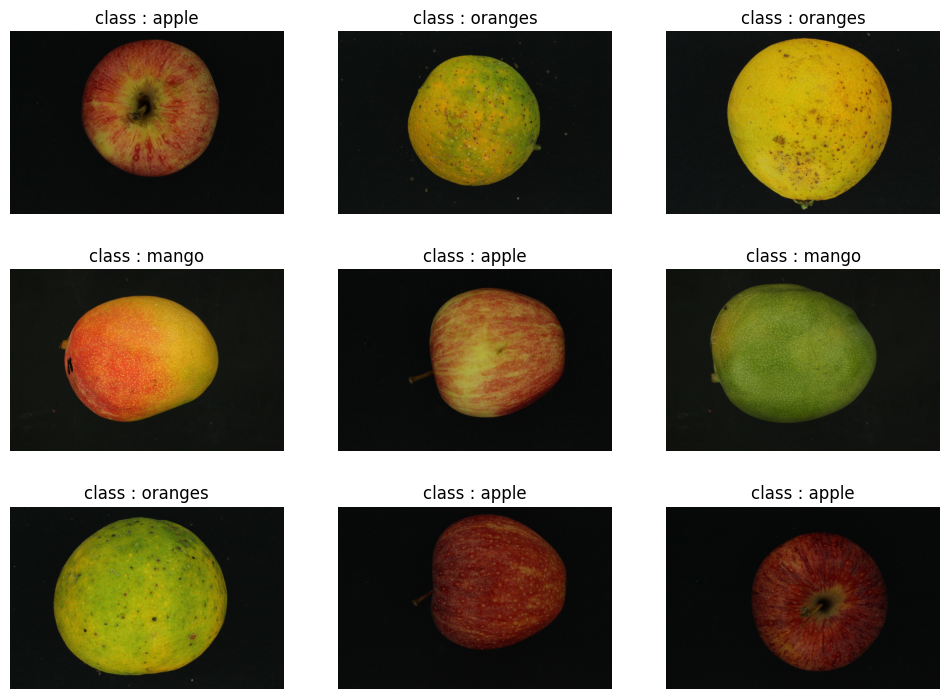

In [5]:
n = rnd.randint(9, 9)
x_value = max(int(math.sqrt(n)), 2)
y_value = max(n - x_value, 2)

plt.figure(figsize=(x_value * 4, y_value * 3))
for idx, i in enumerate(rnd.sample(range(len(data)), n)):
    plt.subplot(y_value, x_value, idx + 1)
    plt.title(f"class : {data[i][0]}")
    plt.axis("off")
    plt.imshow(cv2.cvtColor(data[i][1], cv2.COLOR_BGR2RGB))

plt.show()

## Split dataset

In [3]:
def split_dataset(inputs, outputs, percentage):
    x_train, y_train, x_test, y_test = [], [], [], []
    n = len(inputs)
    indicator = rnd.sample(range(n+1), n)
    for i in range(len(inputs)):
        if indicator[i] > int(n*percentage):
            x_test.append(inputs[i])
            y_test.append(outputs[i])
        else:
            x_train.append(inputs[i])
            y_train.append(outputs[i])
    return x_train, y_train, x_test, y_test

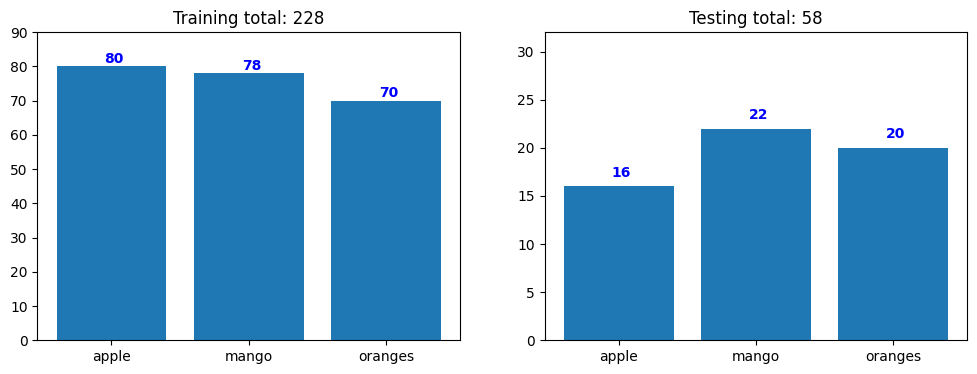

In [7]:
percentage = 0.8 
x_train, y_train, x_test, y_test = split_dataset(data[:,1], data[:,0], percentage)

# Visualizing the split
classes = np.unique(y_train)
train_unique = np.array(np.unique(y_train, return_counts=True))[1].astype(int)
test_unique = np.array(np.unique(y_test, return_counts=True))[1].astype(int)

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.title(f"Training total: {len(x_train)}")
plt.bar(classes, train_unique)
plt.ylim((0, np.amax(train_unique) + 10))
for i, v in enumerate(train_unique):
    plt.text(i - 0.05, v + 1, str(v), color="blue", fontweight="bold")

fig.add_subplot(1, 2, 2)
plt.title(f"Testing total: {len(x_test)}")
plt.bar(classes, test_unique)
plt.ylim((0, np.amax(test_unique) + 10))
for i, v in enumerate(test_unique):
    plt.text(i - 0.05, v + 1, str(v), color="blue", fontweight="bold")

plt.show()


## Histogram of Oriented Gradients

In [8]:
def HOG(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(3, 3),
):
    image = np.atleast_2d(image)
    image = image.astype(np.float64, copy=False)

    # Hog channel gradient
    gradient_columns = np.empty(image.shape, dtype=image.dtype)
    gradient_columns[:, 0] = 0
    gradient_columns[:, -1] = 0
    gradient_columns[:, 1:-1] = image[:, 2:] - image[:, :-2]
    gradient_rows = np.empty(image.shape, dtype=image.dtype)
    gradient_rows[0, :] = 0
    gradient_rows[-1, :] = 0
    gradient_rows[1:-1, :] = image[2:, :] - image[:-2, :]

    size_rows, size_columns = image.shape[:2]
    cell_rows, cell_columns = pixels_per_cell
    b_row, b_col = cells_per_block

    n_cells_rows = int(size_rows // cell_rows)
    n_cells_cols = int(size_columns // cell_columns)

    orientation_histogram = np.zeros(
        (n_cells_rows, n_cells_cols, orientations), dtype=float
    )
    gradient_rows = gradient_rows.astype(float, copy=False)
    gradient_columns = gradient_columns.astype(float, copy=False)

    # Hog histograms
    magnitude = np.hypot(gradient_columns, gradient_rows)
    orientation = np.rad2deg(np.arctan2(gradient_rows, gradient_columns)) % 180

    r_0 = cell_rows // 2
    c_0 = cell_columns // 2
    cc = cell_rows * n_cells_rows
    cr = cell_columns * n_cells_cols
    range_rows_stop = (cell_rows + 1) // 2
    range_rows_start = -(cell_rows // 2)
    range_columns_stop = (cell_columns + 1) // 2
    range_columns_start = -(cell_columns // 2)
    number_of_orientations_per_180 = 180.0 / orientations

    for i in range(orientations):
        orientation_start = number_of_orientations_per_180 * (i + 1)
        orientation_end = number_of_orientations_per_180 * i
        column_index = c_0
        row_index = r_0
        r_i = 0
        c_i = 0

        while row_index < cc:
            c_i = 0
            column_index = c_0

            while column_index < cr:
                # Hog cell
                total = 0.0
                for cell_row in range(range_rows_start, range_rows_stop):
                    cell_row_index = row_index + cell_row
                    if cell_row_index < 0 or cell_row_index >= size_rows:
                        continue

                    for cell_column in range(range_columns_start, range_columns_stop):
                        cell_column_index = column_index + cell_column
                        if (
                            cell_column_index < 0
                            or cell_column_index >= size_columns
                            or orientation[cell_row_index, cell_column_index]
                            >= orientation_start
                            or orientation[cell_row_index, cell_column_index]
                            < orientation_end
                        ):
                            continue

                        total += magnitude[cell_row_index, cell_column_index]

                orientation_histogram[r_i, c_i, i] = total / (cell_rows * cell_columns)
                c_i += 1
                column_index += cell_columns

            r_i += 1
            row_index += cell_rows

    # Blocks normalization
    n_blocks_row = (n_cells_rows - b_row) + 1
    n_blocks_col = (n_cells_cols - b_col) + 1
    normalized_blocks = np.zeros(
        (n_blocks_row, n_blocks_col, b_row, b_col, orientations), dtype=np.float64
    )

    for row_index in range(n_blocks_row):
        for column_index in range(n_blocks_col):
            block = orientation_histogram[
                row_index : row_index + b_row, column_index : column_index + b_col, :
            ]

            eps = 1e-5
            # Normalization using L2-norm
            normalized = block / np.sqrt(np.sum(block**2) + eps**2)
            # Limiting the maximum values to 0.2
            normalized = np.minimum(normalized, 0.2)
            # Renormalization using L2-norm.
            normalized = normalized / np.sqrt(np.sum(normalized**2) + eps**2)
            normalized_blocks[row_index, column_index, :] = normalized

    # Return feature vector
    return normalized_blocks.ravel()


In [9]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    img = HOG(
        img,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
    )
    return img


# images = np.vectorize(preprocess_image)(data[:, 1])
x_train_processed = np.array(list(map(preprocess_image, x_train)))
x_test_processed = np.array(list(map(preprocess_image, x_test)))

## K-Nearest Neighbors algorithm

In [10]:
class KNN:
    def __init__(self, k = None, inputs = None, outputs = None):
        self.k = k
        self.inputs = inputs
        self.outputs = outputs

    def flatten(self, img):
        height, width, channels = data[0][1].shape
        return np.reshape(np.array(img), (height * width, channels))
    
    def euclidian_distance(self, img1, img2):
        return np.linalg.norm(img1 - img2)

    def predict(self, x_test):
        predictions = []
        for img1 in x_test:
            neighbors = [
                [self.outputs[idx], self.euclidian_distance(img1, img2)]
                for idx, img2 in enumerate(self.inputs)
            ]
            neighbors.sort(key=lambda x: x[1])

            nearest_neighbors = [
                neighbors[: self.k][i][0] for i in range(len(neighbors[: self.k]))
            ]

            (label, frequency) = np.unique(nearest_neighbors, return_counts=True)
            label_frequency = list(zip(label, frequency))
            label_frequency.sort(key=lambda x: x[1], reverse=True)
            predictions.append(label_frequency[0][0])
        return predictions


In [11]:
knn = KNN(
    k=8,
    inputs=x_train_processed,
    outputs=y_train,
)

predictions = knn.predict(x_test_processed)
print("Finished.")

Finished.


## Validation

In [12]:
correct = sum(
    [1 for idx, prediction in enumerate(predictions) if prediction == y_test[idx]]
)

print(f"Correct: {correct}")
print(f"Total: {len(predictions)}")
print(f"Accuracy: {round(correct/len(predictions) * 100, 2)}%")


Correct: 53
Total: 58
Accuracy: 91.38%


## Validation Visualization

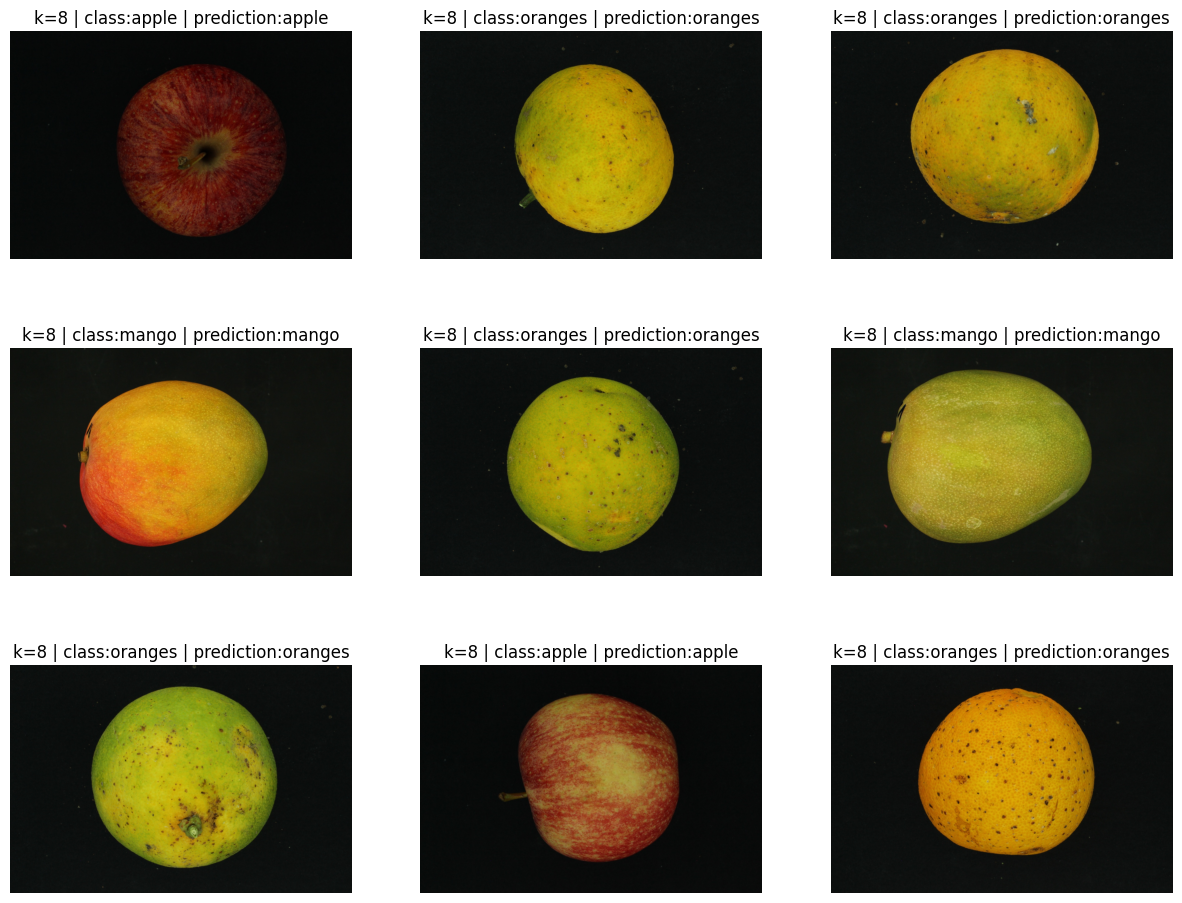

In [83]:
n = 9
x_align = max(int(math.sqrt(n)), 2)
y_align = max(n - x_align, 2)

plt.figure(figsize=(x_align * 5, y_align * 4))
for idx, i in enumerate(rnd.sample(range(len(x_test)), n)):
    plt.subplot(y_align, x_align, idx + 1)
    title = f"k={knn.k} | class:{y_test[i]} | prediction:{predictions[i]}"
    plt.title(title)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB))

plt.show()

## Random K Validation Visualization

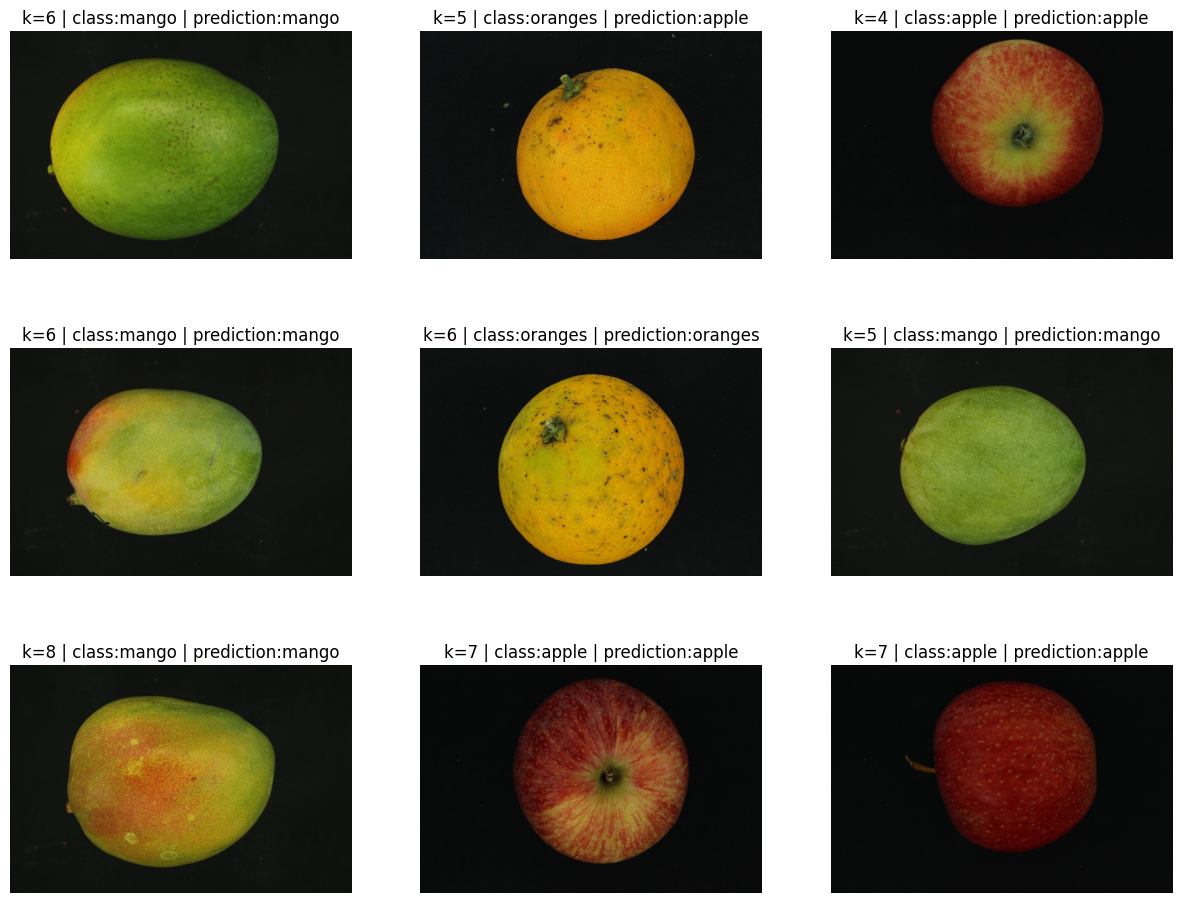

In [84]:
n = 9
x_align = max(int(math.sqrt(n)), 2)
y_align = max(n - x_align, 2)

plt.figure(figsize=(x_align * 5, y_align * 4))
for idx, i in enumerate(rnd.sample(range(len(x_test)), n)):
    knn.k = np.random.randint(3, 9)
    prediction = knn.predict([x_test_processed[i]])
    plt.subplot(y_align, x_align, idx + 1)
    title = f"k={knn.k} | class:{y_test[i]} | prediction:{prediction[0]}"
    plt.title(title)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB))

plt.show()
